# Introduction

The attached file has 5 tabs:

* 3 tabs are billing info per month (Jan, Feb, March)
* The fourth tab is "Clients Rates"
* The last tab is "Vendor Rates"

The rates file has the number type along with the rate from Landline and Mobile.

**Important Notes:**

* Month tabs billing is in SECONDS, but clients are billed per minute. (61 seconds = 2 minutes)
* Vendors charge in different increments:
    * Vendor 1: Billed every 6 seconds (7 seconds = 12 seconds)
    * Vendor 2: Billed per second
    * Vendor 3: Billed per minute
    * Vendor 4: Billed for the first 30 seconds, then every 6 seconds after.
    * Vendor 5: Billed every 30 seconds.

**Requested Analysis:**

* Total billing per client
* Gross Margins by Client (in %)
* Gross Margins by Country (in %)
* Gross Margins by Carrier (in %)
* Gross Margins by Number (in %)
* Total Cost per Vendor
* Gross Margin by Country/Carrier/Client

# Data Cleaning

- Account ID (phone mumber) = '-2147483648' didn't have any information in the rates sheets. These were dropped from the dataset (+50%)
- Most of the calls happen in month = 'Feb'. This should be taken into account when interpreting the results.
- Analysis was done on all data from all months combined
- Overall data quality is good (7/10)

# Base functions

- These are functions used for calculating the following:
  - applicable rate for each call
  - billing minutes(company)
  - billing minutes(vendor)
  - cost
  - revenue
  - profit
  - gross margin

In [930]:
import pandas as pd 
import matplotlib as plt
#import plotly.io as pio
#pio.renderers.default = 'jupyterlab'

#pio.renderers.default = None

#print(pio.renderers)
def get_file( file_path):
    
    source_data = pd.read_excel(file_path,sheet_name=None)
    return source_data

In [931]:
def get_sheets(source_data):
    jan_df = source_data['Jan']
    jan_df['Month'] = 'Jan'

    feb_df = source_data['Feb']
    feb_df['Month'] = 'Feb'

    march_df = source_data['March']
    march_df['Month'] = 'March'
    
    
    rates_client = source_data['Rates - Clients']
    rates_vendor = source_data['Rates - Carrier']

    return jan_df, feb_df,march_df,rates_client,rates_vendor


In [932]:
def concat_months(*args):
    all_month_data = pd.concat(args)
    all_month_data.dropna(subset = ['Customer'], inplace = True)
    return all_month_data


    

In [933]:
def all_data_with_vender_and_client(all_month_data,client_rate,vendor_data):
    all_month_data['Account ID (phone mumber)']  = all_month_data['Account ID (phone mumber)'].astype(int).astype(str)
    client_rate['Account ID (phone mumber)']  = client_rate['Account ID (phone mumber)'].astype(str)
    vendor_data['Account ID (phone mumber)']  = vendor_data['Account ID (phone mumber)'].astype(str)
    
    all_month_data = all_month_data.merge(client_rate, on = 'Account ID (phone mumber)',how='left') #adding client rates
    all_month_data = all_month_data.merge(vendor_data,on = 'Account ID (phone mumber)' , how = 'left') #adding vendor rates

    all_month_data.dropna(subset = ['Country_x'],inplace = True)
    
    return all_month_data

In [934]:
def calculate_billing_minutes_vendor(vendor , seconds):
    # Vendor 1 - Bill for every 6 seconds (if the call goes on for 7 seconds we get billed 12 seconds etc)

    # Vendor 2- Per second

    # Vendor 3 per minute

    # Vendor 4 - we get billed for the first 30 seconds and then afterwards 6 seconds

    # Vendor 5 - every 30 seconds
    
    import math 
    if vendor == 'Vendor 1':
        return math.ceil(seconds / 6) * 6 /60 #calculating billable seconds and then billable minutes

    elif vendor == 'Vendor 2':
        return seconds / 60 
        
    elif vendor == 'Vendor 3':
        return math.ceil(seconds /60)

    elif vendor == 'Vendor 4':
        if seconds <= 30:
            billable_seconds = 30
        else:
            billable_seconds = 30 + math.ceil((seconds - 30) / 6) * 6

        return billable_seconds / 60

    elif vendor == 'Vendor 5':
        return math.ceil(seconds / 30) * 30 / 60

    else: 
        return seconds / 60
    

In [935]:
def calculate_billing_minutes_company(all_data_client_vnedor):
    import math
    #the same rule is used to calculate the billing minutes for all customers 
    all_data_client_vnedor['company_billing_minutes'] = all_data_client_vnedor.apply(lambda x : math.ceil(x['Duration (Seconds)']/60),axis=1)
    return all_data_client_vnedor

In [936]:
def calculate_revenue(df_with_billable_minutes):

    df_with_billable_minutes['revenue'] = df_with_billable_minutes.apply(
    lambda x: (x['company_billing_minutes'] * x['LandLine Rate_x']) if x['Called From'] == 'Landline' 
              else (x['company_billing_minutes'] * x['Mobile Rate_x']), axis=1
                                                                        )

    return df_with_billable_minutes

def calculate_cost(df_with_revenue):

    df_with_revenue['cost'] = df_with_revenue.apply(
    lambda x: (x['vendor_billing_minutes'] * x['LandLine Rate_y']) if x['Called From'] == 'Landline' 
              else (x['vendor_billing_minutes'] * x['Mobile Rate_y']), axis=1
                                                                        )

    return df_with_revenue

def calcualte_profit(df_with_revenue_cost):
    df_with_revenue_cost['profit'] =df_with_revenue_cost['revenue'] - df_with_revenue_cost['cost']
    return df_with_revenue_cost


def calculate_gross_margin(df_with_profit_revenue):
    df_with_profit_revenue['gross_margin'] = df_with_profit_revenue['profit'] / df_with_profit_revenue['revenue']
    df_with_profit_revenue['gross_margin_%'] = df_with_profit_revenue['gross_margin'] * 100
    return df_with_profit_revenue

In [937]:
def update_rates_exp(df_before_calculations,land_increase=0, mobile_increase=0):
    land_multi = 1 + land_increase/100
    mobile_multi = 1 + mobile_increase/100

    df_before_calculations.loc[:,'LandLine Rate_x'] = df_before_calculations['LandLine Rate_x'] * land_multi
    df_before_calculations.loc[:,'Mobile Rate_x'] = df_before_calculations['Mobile Rate_x'] * mobile_multi

    
    return df_before_calculations

In [938]:


file_path = 'Billing_File_022025.xlsx'


source_data = get_file(file_path)


In [939]:
#creating applicable rate column

def create_applicable_rate(df_with_gross_margin):
    df_with_gross_margin['applicable_rate'] = df_with_gross_margin.apply(lambda x : x['LandLine Rate_x'] if x['Called From'] == 'Landline' else x['Mobile Rate_x'],axis = 1 )
    return df_with_gross_margin

In [940]:
jan_df, feb_df,march_df,rates_client,rates_vendor = get_sheets(source_data)
all_month_data = concat_months(jan_df,feb_df,march_df)
month_data_with_client_vender = all_data_with_vender_and_client(all_month_data,rates_client,rates_vendor)
all_data_with_billing_company = calculate_billing_minutes_company(month_data_with_client_vender)
all_data_with_billing_company['vendor_billing_minutes'] = all_data_with_billing_company.apply(lambda x: calculate_billing_minutes_vendor(x['Vendor'],x['Duration (Seconds)']),axis = 1)


all_data_with_billing_company = create_applicable_rate(all_data_with_billing_company)

#scaling_factor_45_margin = 19.96041058268363
land_rate_increase_factor =0
mobile_rate_increase_factor= 0
all_data_with_billing_company = update_rates_exp(all_data_with_billing_company,land_rate_increase_factor,mobile_rate_increase_factor)

df_with_revenue = calculate_revenue(all_data_with_billing_company) 

df_with_cost = calculate_cost(df_with_revenue)

df_with_profit = calcualte_profit(df_with_cost)

df_with_gross_margin = calculate_gross_margin(df_with_profit)

# Margin Calculations

- The following section shows the results of the calculations. It is organized in the following format:
   - Metric name
   - result table
   - graph


# Aggregated Gross Margin by Client

In [941]:
gross_margin_by_customer = df_with_gross_margin.groupby('Customer').apply(
    lambda x : ( x['profit'].sum() / x['revenue'].sum())*100
    
).reset_index(name='Gross_Margin_Percentage')

C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\2285924029.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [942]:
gross_margin_by_customer

,Customer,Gross_Margin_Percentage
0,Client 1,34.702850
1,Client 11,50.000000
2,Client 12,39.920575
3,Client 15,33.638491
4,Client 16,72.820513
5,Client 17,25.367647
6,Client 2,36.918136
7,Client 20,40.460570
8,Client 21,30.000000
9,Client 26,34.328654


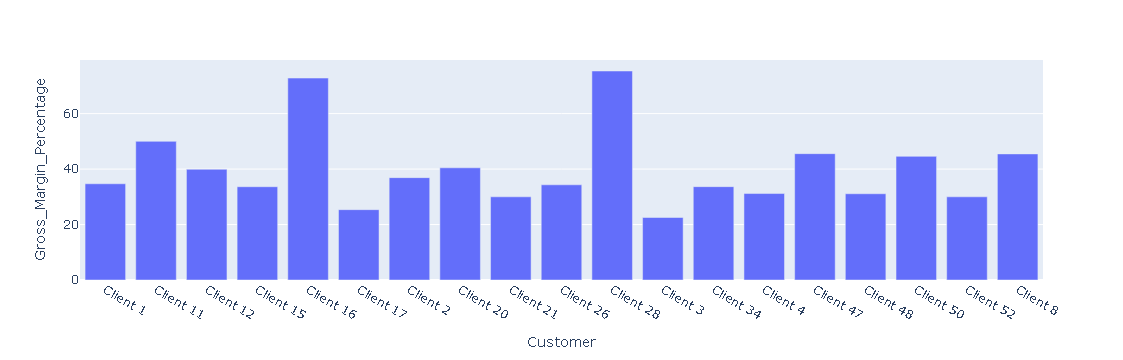

In [943]:
import plotly.express as px

fig_customer_margin = px.bar(gross_margin_by_customer, x='Customer', y='Gross_Margin_Percentage')
fig_customer_margin.show()


# Aggregated Gross Margin by Country

In [944]:
gross_margin_by_country = df_with_gross_margin.groupby('Country_x').apply(
    lambda x : ( x['profit'].sum() / x['revenue'].sum())*100
    
).reset_index(name='Gross_Margin_Percentage')

C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\158724486.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [945]:
gross_margin_by_country

,Country_x,Gross_Margin_Percentage
0,Australia,39.322561
1,China,38.370164
2,Greece,36.158861
3,United States,28.993069


In [946]:
fig_country_margin = px.bar(gross_margin_by_country, x ='Country_x' , y ='Gross_Margin_Percentage')
fig_country_margin.show()

# Aggregated Gross Margin by Vendor


In [947]:
gross_margin_by_vendor = df_with_gross_margin.groupby('Vendor').apply(
    lambda x : ( x['profit'].sum() / x['revenue'].sum())*100
    
).reset_index(name='Gross_Margin_Percentage')

C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\1270278673.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [948]:
gross_margin_by_vendor

,Vendor,Gross_Margin_Percentage
0,Vendor 1,41.058572
1,Vendor 2,38.925870
2,Vendor 3,32.144591
3,Vendor 4,31.076139
4,Vendor 5,43.432268


In [949]:
fig_vendor_margin = px.bar(gross_margin_by_vendor , x='Vendor' , y='Gross_Margin_Percentage')
fig_vendor_margin

# Aggregated Gross Margin by call type(mobile, land)


In [950]:
gross_margin_by_call_type = df_with_gross_margin.groupby('Called From').apply(
    lambda x : ( x['profit'].sum() / x['revenue'].sum())*100
    
).reset_index(name='Gross_Margin_Percentage')

C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\1390957845.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [951]:
gross_margin_by_call_type

,Called From,Gross_Margin_Percentage
0,Landline,33.083801
1,Mobile,35.136063


In [952]:
fig_call_type_margin = px.bar(gross_margin_by_call_type , x='Called From' , y='Gross_Margin_Percentage')
fig_call_type_margin

# Total Revenue per Client


In [953]:
total_revenue_by_customer = df_with_gross_margin.groupby('Customer').apply(
    lambda x : x['revenue'].sum()
    
).reset_index(name='Total_revenue')



C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\1301692444.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [954]:
total_revenue_by_customer

,Customer,Total_revenue
0,Client 1,1430.752
1,Client 11,66.700
2,Client 12,66.100
3,Client 15,369.700
4,Client 16,1.300
5,Client 17,0.102
6,Client 2,197.002
7,Client 20,119.200
8,Client 21,25.000
9,Client 26,224.400


In [955]:
fig_total_revenue_customer = px.bar(total_revenue_by_customer, x='Customer', y='Total_revenue')
fig_total_revenue_customer

# Total Cost per Vendor

In [956]:
total_cost_by_vendor = df_with_gross_margin.groupby('Vendor').apply(
    lambda x : x['cost'].sum()
    
).reset_index(name='Total_cost')

C:\Users\Ahmed Ahmed\AppData\Local\Temp\ipykernel_2912\988361402.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [957]:
total_cost_by_vendor

,Vendor,Total_cost
0,Vendor 1,163.344380
1,Vendor 2,529.816247
2,Vendor 3,1106.799750
3,Vendor 4,3477.419000
4,Vendor 5,704.452675


In [958]:
fig_total_cost_vendor = px.bar(total_cost_by_vendor,x='Vendor',y='Total_cost')
fig_total_cost_vendor

# Overall Gross Margin

- This is the overall gross margin using the defualt rates

In [959]:
overall_gross_margin = (df_with_gross_margin['profit'].sum() / df_with_gross_margin['revenue'].sum())*100 
print('The overall default gross margin is equal to: ' , overall_gross_margin,'%')

The overall default gross margin is equal to:  34.02177417952398 %


# Optimizing_rates for 45% gross margin
-two examples of rate optimization are explored:

    - non-uniform rate optimiztion: This shows how the rate should change per call!
    - uniform rate optimization: This shows how all the rates would increase

In [960]:
import numpy as np

def optimize_rates_nonuniform(original_rates, billable_minutes, costs, target_gm=0.45):
   
    # target_gm: target gross margin (0.45 for 45%).
    
    total_cost = np.sum(costs)
    
   
    desired_revenue = total_cost / (1 - target_gm)  # Here, (1 - 0.45) = 0.55.
    
    # This is the sum of each call's revenue: rate * minutes.
    R_orig = np.dot(original_rates, billable_minutes)
    
    # This is the sum of the squares of the billable minutes.
    sum_minutes_squared = np.sum(billable_minutes**2)
    
    # lambda = 2 * (R_orig - desired_revenue) / (sum of billable_minutes^2)
    lambda_val = 2 * (R_orig - desired_revenue) / sum_minutes_squared
    
    # x_i = r_i - (lambda * m_i) / 2, which is equivalent to:
    optimized_rates = original_rates - (lambda_val * billable_minutes) / 2
    
    # optimized_rates = original_rates + (billable_minutes * (desired_revenue - R_orig)) / sum_minutes_squared
    
    return optimized_rates



In [961]:

# Suppose we have the following sample data:
original_rates = df_with_gross_margin['applicable_rate'] # call rates in dollars per minute
billable_minutes = df_with_gross_margin['company_billing_minutes']             # billable minutes per call
costs = df_with_gross_margin['cost']                            # costs associated with each call

# We want to adjust the rates so that overall, the gross margin becomes 45%
optimized_rates = optimize_rates_nonuniform(original_rates, billable_minutes, costs, target_gm=0.45)
print("Optimized Rates:", optimized_rates)


Optimized Rates: 0        0.004820
1        0.004820
2        0.008639
3        0.004820
4        0.002910
           ...   
69668    0.201910
69669    0.211459
69704    0.105729
69705    0.201910
69721    0.201910
Length: 15111, dtype: float64


In [962]:
df_with_gross_margin['non_uniform_Optimized Rates'] = optimized_rates

In [963]:
df_with_gross_margin.head(3)

,Customer,Account ID (phone mumber),Duration (Seconds),Called From,Month,Country_x,Number Type_x,LandLine Rate_x,Mobile Rate_x,Vendor,...,Mobile Rate_y,company_billing_minutes,vendor_billing_minutes,applicable_rate,revenue,cost,profit,gross_margin,gross_margin_%,non_uniform_Optimized Rates
0,Client 1,20100405,114.0,Landline,Jan,Greece,DID,0.001,0.1,Vendor 5,...,0.07,2,2.0,0.001,0.002,0.00140,0.00060,0.300,30.0,0.004820
1,Client 1,20100405,72.0,Landline,Jan,Greece,DID,0.001,0.1,Vendor 5,...,0.07,2,1.5,0.001,0.002,0.00105,0.00095,0.475,47.5,0.004820
2,Client 1,20100405,231.0,Landline,Jan,Greece,DID,0.001,0.1,Vendor 5,...,0.07,4,4.0,0.001,0.004,0.00280,0.00120,0.300,30.0,0.008639


In [964]:
df_with_gross_margin['rate_percentage_increase'] = (df_with_gross_margin['non_uniform_Optimized Rates'] - df_with_gross_margin['applicable_rate']) / df_with_gross_margin['applicable_rate'] * 100 

In [965]:
import numpy as np

def optimize_rates_uniform(original_rates, billable_minutes, costs, target_gm=0.45):
    
    
    total_cost = np.sum(costs)
    
    
    # Gross margin formula rearranged: Revenue = Total Cost / (1 - target_gm)
    desired_revenue = total_cost / (1 - target_gm)
    
    
    # This is the sum of each call's revenue: original_rate * billable_minutes.
    original_revenue = np.dot(original_rates, billable_minutes)
    
    
    # We want: new_total_revenue = k * original_revenue = desired_revenue.
    scaling_factor = desired_revenue / original_revenue
    
    # Step 5: Apply the scaling factor to all original rates to get the optimized rates.
    optimized_rates = original_rates * scaling_factor
    
    return optimized_rates, scaling_factor


    

In [966]:
# Adjust rates uniformly to achieve a 45% gross margin.
uni_optimized_rates, uni_scaling_factor = optimize_rates_uniform(original_rates, billable_minutes, costs, target_gm=0.45)
    
print("Uniform Scaling factor:", uni_scaling_factor)


Uniform Scaling factor: 1.1996041058268363


In [967]:
df_with_gross_margin['uniform_optimized_rates'] = uni_optimized_rates

In [968]:
uni_scaling_factor

1.1996041058268363

# Overall gross margin(After uniform rate optimization)

In [969]:
revenue_optimized = df_with_gross_margin['company_billing_minutes'] * df_with_gross_margin['uniform_optimized_rates']
profit_optimized = revenue_optimized - df_with_gross_margin['cost']
overall_gross_margin = (profit_optimized.sum() / revenue_optimized.sum())*100 
print('The overall gross margin is equal to: ' , overall_gross_margin,'%')

The overall gross margin is equal to:  44.99999999999998 %


# optimizing the rates for land and mobile separately 

- the following shows how the rates for land and mobile would be optimized separately to achieve 45% gross margin separately


In [970]:
df_land = df_with_gross_margin[df_with_gross_margin['Called From'] == 'Landline'].copy()

In [971]:
df_mobile = df_with_gross_margin[df_with_gross_margin['Called From'] == 'Mobile'].copy()

In [972]:
# Example usage:
# Suppose we have the following sample data:
land_original_rates = df_land['applicable_rate'] # call rates in dollars per minute
land_billable_minutes = df_land['company_billing_minutes']             # billable minutes per call
land_costs = df_land['cost']                            # costs associated with each call

land_uni_optimized_rates, land_uni_scaling_factor = optimize_rates_uniform(land_original_rates, land_billable_minutes, land_costs, target_gm=0.45)
land_uni_scaling_factor
print('Scalling factor for land rates: ' , land_uni_scaling_factor)

Scalling factor for land rates:  1.2166581685235278


In [973]:
# Example usage:
# Suppose we have the following sample data:
mobile_original_rates = df_mobile['applicable_rate'] # call rates in dollars per minute
mobile_billable_minutes = df_mobile['company_billing_minutes']             # billable minutes per call
mobile_costs = df_mobile['cost']                            # costs associated with each call

mobile_uni_optimized_rates, mobile_uni_scaling_factor = optimize_rates_uniform(mobile_original_rates, mobile_billable_minutes, mobile_costs, target_gm=0.45)
mobile_uni_scaling_factor
print('Scalling factor for mobile rates: ' , mobile_uni_scaling_factor)

Scalling factor for mobile rates:  1.179344315814148


# Gross Margin optimiztion summary:

- default total gross margin before rate optimization = 34.02177417952398 %
- total gross margin after increasing mobile rate by 7% and the landline rate by 20% = 41.58 %
- total gross margin after increasing both mobile and landline rates by 19.9604 % =  44.9999 %
- optimizing land and mobile rates separately: land 21.6658 % and mobile 17.9344 % = 45.0000%
